# Computer Assignment 6

Write a code that implements a basic form of the block-based hybrid video coder for coding
a P-frame using a fixed block size of 8x8. For simplicity, consider intra-prediction using only
the first 3 intra prediction modes shown below over 8x8 blocks, and inter-prediction using
integer accuracy EBMA, with a specified search range, e.g. +/-24. For inter-prediction, we will use two frames that are 10 frames apart, and use the past frame to predict the future frame.

You program should do the following for each block: 
- i) find the best intra-prediction mode and the corresponding
error block and its MSE; 
- ii) find the best MV for inter-prediction and the corresponding
error block and its MSE; 
- iii) Choose the prediction mode which has smallest MSE; 
- iv) Calculate the error block between the prediction and original
- The above steps should generate a prediction image and an error image

Your progam should then do the following on the error image
- v) Perform 8x8 DCT on each prediction error blocks; 
- vi) Quantize all the DCT coefficients with the same quantization step-size (QS) q; Note that you should assume the prediction error has zero mean and use a quantizer that is symmetric with respect to 0;  
- vii) Count how many non-zero coefficients you have after quantization, 
- viii) Reconstruct the error block by performing inverse DCT on quantized DCT coefficients; 
- ix) Reconstruct the original block by adding the reconstructed error block to the predicted block
- x) Repeat v-ix using different quantization step sizes
- The above steps should genearte a reconstructed image

![img](img.png)

- Although the figure shows 4x4 block size, we will be using 8x8 blocks. Intraprediction rules are the same.

Instead of developing a real entropy coder, we will use the total number of non-zero DCT coefficients as an
estimate of the bit rate and ignore the bits needed to code the side information (mode info,
motion vector, etc.). Your program should determine the PSNR of the reconstructed image
(compared to the original image) and the total number of non-zero quantized DCT
coefficients K, for a given quantization step-size q.

You should repeat operations(v-ix) for a set of q=4, 16, 32, 64, 128 and determine the PSNR and K for each q, and draw the resulting PSNR vs. K curve, as a substitute for the PSNR vs. rate curve.

**Use the _Football_ video provided in the attachment as test sequence**

**Frames in the video have been extracted for you in .jpg format.**

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm    # Used to display a progress bar while running for-loops
%matplotlib inline

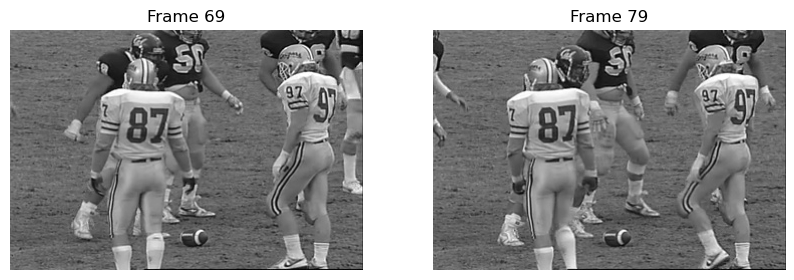

In [36]:
################################################ TODO ###############################################
# Read in two frames that are several frames apart.
# For example, frame100 and frame110
# Read in grayscale mode

#Load a frame from the sequence
img1 = cv2.imread("Football/frame69.jpg", 0) #NICE! 
img1 = img1.astype('float')

# Load another frame that is 10 frames after the above frame
img2 = cv2.imread("Football/frame79.jpg", 0)
img2 = img2.astype('float')

### Plot the two Frames
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img1,cmap='gray')
plt.title('Frame 69') 
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img2,cmap='gray')
plt.title('Frame 79')
plt.axis('off')
plt.show()

In [37]:
###################################  TODO  ###############################
# Define a function to calculate the MSE with the error block as the input
def mse(error):
    return np.mean(np.square(error))

In [38]:
################################################ TODO ###############################################
# Define EBMA() which takes as input the template(target block), image, template location(x0, y0) and search range
# Return the matching block and the motion vector
def EBMA(template,img,x0,y0,range_x,range_y):
    # get the number of rows and columns of the image
    rows, cols = img.shape
    # get the number of rows and columns of the template
    b_rows, b_cols = template.shape
    # initialize maximum error, motion vector and matchblock
    min_mse = float('inf')
    xm = 0
    ym = 0
    matchblock = np.zeros((b_rows,b_cols))
    # loop over the searching range to find the matchblock with the smallest error.
    for i in range(max(1,x0-range_x),min(rows-b_rows,x0+range_x)):
        for j in range(max(1,y0-range_y),min(cols-b_cols,y0+range_y)):
            candidate = img[i:i+b_rows,j:j+b_cols]
            error = template - candidate
            mse_error = mse(error)
            if mse_error < min_mse:
                # update motion vector, matchblock and max_error if the error of the new block is smaller
                xm = i - x0
                ym = j - y0
                matchblock = candidate
                min_mse = mse_error
    return xm, ym, matchblock

In [39]:
################################################ TODO ###############################################
# define quantization function to quantize the dct coefficients
# recall the quantization function: Q(f)=floor( (f-mean+Q/2)/Q) *Q+mean
# Assume the mean of the dct coefficients is 0
def quant(dct_coef, q):
    mean = 0
    dctimg_quant = np.floor((dct_coef - mean + q / 2) / q) * q + mean
    return dctimg_quant

## Generate Predicted Image and Error Image
- We will be coding img2 with intraprediction using reconstructed pixels in the same frame, and interprediction using past frame img1 as reference
- We will assume that the first row and column of the image are already reconstructed.
- Also assume that in both inter and intraprediction, the reference pixels were perfectly reconstructed. So we can use the original pixels from img1 and img2 as reference in prediction.

- This section of code will generate two images:

    - **Predicted Image**: Image predicted via intra and inter modes using reference pixels from img2 and img1
    - **Error Image**: Unquantized image of the error between predicted image and original image

In [40]:
################################################ TODO ###############################################
# define searching range for EBMA
range_x = 24    
range_y = 24

# get the row and column size of the images.
rows, cols = img1.shape
# define the block size
N = 8

# Pad the right and bottom sides of image 2, so that the image dimensions (minus the first row/col) is a multiple of N.
img2_pad = np.pad(img2, [[0,N-(rows-1)%N],[0,N-(cols-1)%N]], mode ='edge')

################################################ TODO ###############################################
# initialize the predicted image as zeros with same size as img2_pad
pred_img_pad = np.zeros(img2_pad.shape)
# Assume first row & col are already reconstructed, copy them directly form img2
pred_img_pad[0,:] = img2_pad[0,:]
pred_img_pad[:,0] = img2_pad[:,0]
# Initializae an array for error image, which we will be reusing for the next part
err_img_pad = np.zeros(img2_pad.shape)

################################################ TODO ###############################################
# Loop through all blocks and for each block find mode that has minimum error
for x0 in tqdm(np.arange(1,(rows-1), N)):
    for y0 in np.arange(1,(cols-1), N):
        #get the current block
        patch = img2_pad[x0:x0+N,y0:y0+N]
        min_MSE=255**2 

        # mode 0  Vertical
        pred_block = np.zeros((N,N))
        # Vertical perdiction to fill pred_block
        for i in range(N):
            for j in range(N):
                if j == 0:
                    pred_block[i,j] = img2_pad[x0+i-1,y0-1]
                else:
                    pred_block[i,j] = pred_block[i,j-1]
        # get the error block between the predicted block and the current block
        err_block = patch - pred_block
        # calculate the mse of the error block
        current_mse = mse(err_block)
        # update the predicted block and error block if the mse is smaller
        if current_mse < min_MSE: 
            min_pred_block = pred_block.copy()
            min_err_block = err_block.copy()
            min_MSE = current_mse
            
        # mode 1  Horizontal
        pred_block = np.zeros((N,N))
        # Horizontal perdiction to fill pred_block
        for i in range(N):
            for j in range(N):
                if i == 0:
                    pred_block[i,j] = img2_pad[x0-1,y0+j-1]
                else:
                    pred_block[i,j] = pred_block[i-1,j]
        err_block = patch - pred_block
        current_mse = mse(err_block)
        if current_mse < min_MSE: 
            min_pred_block = pred_block.copy()
            min_err_block = err_block.copy()
            min_MSE = current_mse
        
        #mode 2: DC
        pred_block = np.zeros((N,N))
        # DC prediction
        pred_block = np.full((N,N),np.mean(patch))
        err_block = patch - pred_block
        current_mse = mse(err_block)
        if current_mse < min_MSE: 
            min_pred_block = pred_block.copy()
            min_err_block = err_block.copy()
            min_MSE = current_mse

        #inter-prediction
        #perform EBMA to the current block to find best match in img1
        xm, ym, pred_block = EBMA(patch,img1,x0,y0,range_x,range_y)
        err_block = pred_block - patch
        current_mse = mse(err_block)
        if current_mse < min_MSE: 
            min_pred_block = pred_block.copy()
            min_err_block = err_block.copy()
            min_MSE = current_mse
        
        ## Put the min_pred_block and min_err_block in the correct position in the output images
        pred_img_pad[x0:x0 + N, y0:y0 + N] = min_pred_block
        err_img_pad[x0:x0 + N, y0:y0 + N] = min_err_block

# Remove padding
pred_img = pred_img_pad[0:rows,0:cols]
err_img = err_img_pad[0:rows,0:cols]

100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


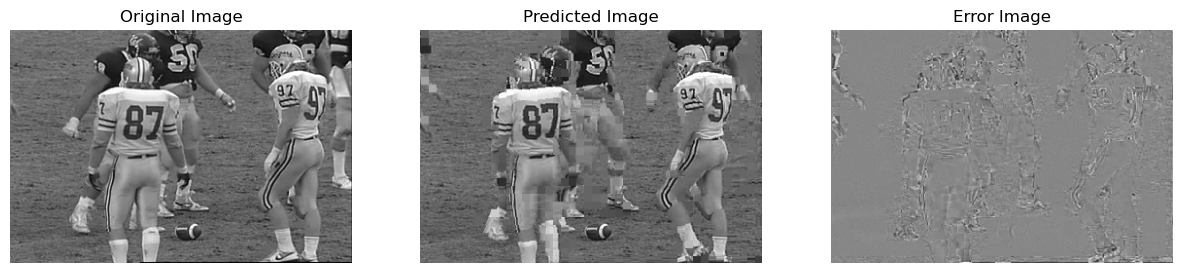

In [41]:
################################################ TODO ###############################################
# plot the original image, predicted image, error image
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(img1,cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(pred_img,cmap='gray')
plt.title('Predicted Image')
plt.axis('off')
plt.subplot(133)
plt.imshow(err_img,cmap='gray')
plt.title('Error Image')
plt.axis('off')
plt.show()


## Test different quantization step sizes
- Using the err_img_pad from above, quantize the error image with different step sizes. Then add to the predicted image to generate the reconstructed image. Test different step sizes and evaluate PSNR.

In [46]:
################################################ TODO ###############################################
# QUANTIZE WITH DIFFERENT STEP SIZE: 4, 16, 32, 64, 128
Q_list = [4, 16, 32, 64, 128]

# Lists to hold reconstructed image, non-zero counts, psnr
Rec_img =[]
Non_zero = []
PSNR = []

for q in Q_list:
    non_zero = 0
    rec_img_pad = np.zeros(img2_pad.shape)
    # Assume first row & col are already reconstructed, copy them directly form img2
    rec_img_pad[0,:] = img2_pad[0,:]
    rec_img_pad[:,0] = img2_pad[:,0]
    for x0 in np.arange(1,(rows-1), N):
        for y0 in np.arange(1,(cols-1), N):
            # extract current error block from the error image
            err_block = err_img_pad[x0:x0+N,y0:y0+N]
            # perform DCT to the current error block, input astype float
            dct_block = cv2.dct(err_block.astype('float'))
            # quantize the coefficients
            dct_block_quant = quant(dct_block,q)
            # Count number of nonzero in this block, update nonzero
            non_zero += np.count_nonzero(dct_block_quant)
            # IDCT to the quantized dct block, input astype float
            err_block_rec = cv2.idct(dct_block_quant.astype('float')) 
            # reconstruct the block
            rec_img_pad[x0:x0+N, y0:y0+N] = err_block_rec
    # Remove padding
    rec_img = rec_img_pad[0:rows, 0:cols]
    
    # Calculate PSNR, Append items to lists
    psnr = 10 * np.log10(255**2 / mse(img2 - rec_img))
    PSNR.append(psnr)
    Non_zero.append(non_zero)
    # Clip rec_img to (0,255) and change back to uint8
    rec_img = np.clip(rec_img,0,255).astype('uint8')
    Rec_img.append(rec_img)

### Plot the PSNR vs. Nonzero curve, each Reconstructed image with different quantization steps

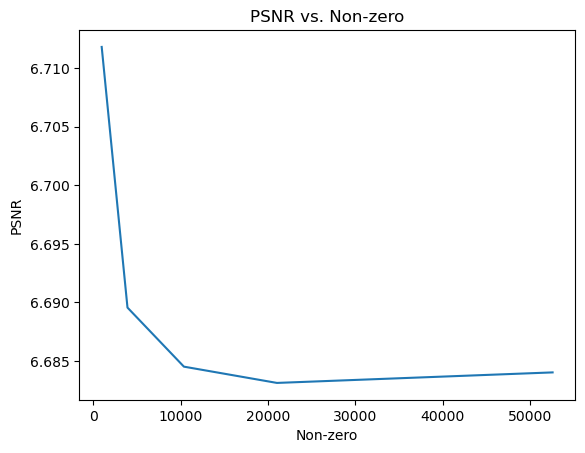

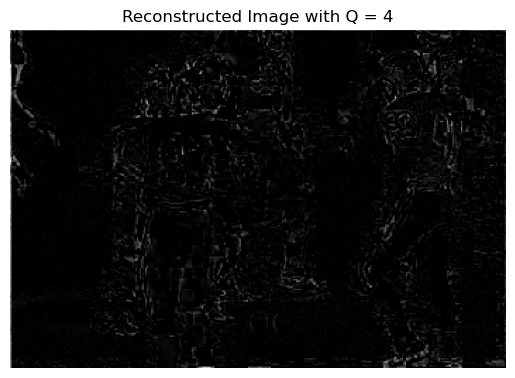

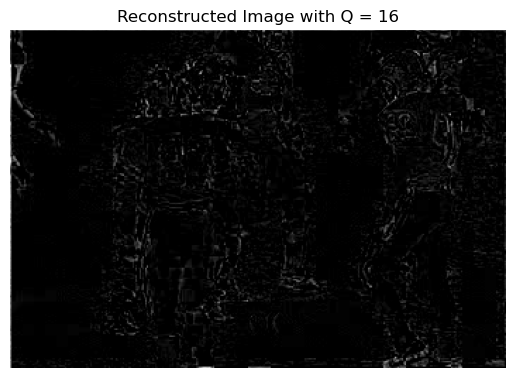

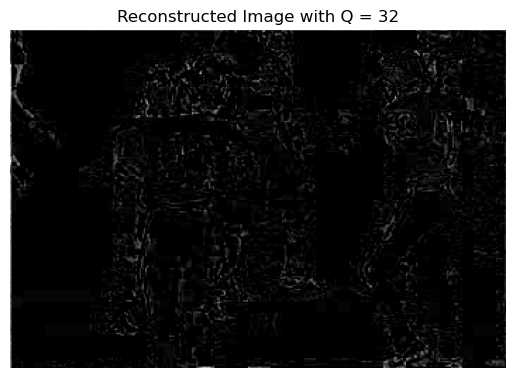

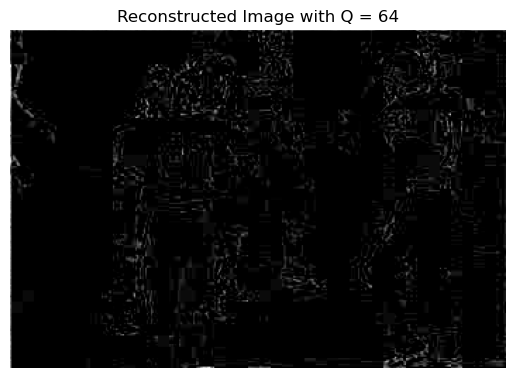

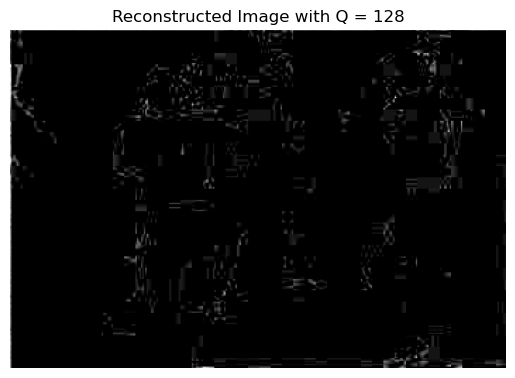

In [47]:
################################################ TODO ###############################################
# Plot the PSNR vs. Nonzero curve, each Reconstructed image with different quantization steps
plt.figure()
plt.plot(Non_zero,PSNR)
plt.xlabel('Non-zero')
plt.ylabel('PSNR')
plt.title('PSNR vs. Non-zero')

for Q in Q_list:
    plt.figure()
    plt.imshow(Rec_img[Q_list.index(Q)],cmap='gray')
    plt.title(f'Reconstructed Image with Q = {Q}')
    plt.axis('off')

In [44]:
# Create a README.md from this notebook
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags ignore CA06-aaz7118.ipynb --to html --template lab
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags ignore CA06-aaz7118.ipynb --to markdown --output README.md

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook CA06-aaz7118.ipynb to html
[NbConvertApp] Writing 1954598 bytes to CA06-aaz7118.html
[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook CA06-aaz7118.ipynb to markdown
[NbConvertApp] Support files will be in README_files\
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 13324 bytes to README.md
